In [22]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from collections import Counter

sys.path.append('../')

In [23]:
from configs.config import CONF

In [24]:
X = np.load(os.path.join(CONF.PATH.DATASET, "one_dice_default", "one_dice.npy"))
y = np.load(os.path.join(CONF.PATH.DATASET, "one_dice_default", "one_dice_labels.npy"))

X.shape, y.shape

((94900, 10, 10), (94900,))

In [25]:
def create_data_dict(id, boxes, labels, area):
    return {
        "image_id": id, 
        "boxes": boxes,
        "labels": labels,
        "area": area,
        "iscrowd": len(boxes)
    }

def add_random_noise(data, composite=False):
    if composite:
        data = data.flatten()
    # 正規分布からランダムな値を20から200個選ぶ
    num_values = np.random.randint(20, 200)
    values = np.random.normal(loc=np.random.randint(20, 120), scale=30, size=num_values)
    values[values < 0] = np.random.randint(1, 50, size=np.sum(values < 0))

    # ランダムな位置に値を追加
    indices = np.random.choice(range(20 * 20), size=num_values, replace=False)
    data[indices] = values

    # 0~255に収める
    data[data < 0] = 0
    data[data > 255] = 255
    if composite:
        data = data.reshape(20, 20)

    return data

def create_one_dice_data(X, y, id, noise=False):
    label = np.random.randint(1, 7)
    indices = np.where(y == label)[0]
    dice_index = np.random.choice(indices)

    data = np.zeros(shape=(20, 20))
    if noise:
        data = add_random_noise(data, composite=True)
    pos_x = np.random.randint(0, 10)
    pos_y = np.random.randint(0, 10)
    data[pos_x : pos_x + 10, pos_y : pos_y + 10] = X[dice_index]
    data_dict = create_data_dict(id, [[pos_x, pos_y, pos_x + 10, pos_y + 10]], [label], [10])

    return data, label, data_dict


def create_two_dices_data(X, y, id, noise=False):
    pattern = id % 2
    dice_pattern = np.random.randint(1, 7, size=2)
    label = dice_pattern.sum()
    dice_index = []
    for i in dice_pattern:
        indices = np.where(y == i)[0]
        dice_index.append(np.random.choice(indices))

    data = np.zeros(shape=(20, 20))
    if noise:
        data = add_random_noise(data, composite=True)
    pos_1 = np.random.randint(0, 10)
    pos_2 = np.random.randint(0, 10)
    boxes = []
    if pattern == 0:
        data[0:10, pos_1 : pos_1 + 10] = X[dice_index[0]]
        data[10:20, pos_2 : pos_2 + 10] = X[dice_index[1]]
        boxes.append([0, pos_1, 10, pos_1 + 10])
        boxes.append([10, pos_2, 20, pos_2 + 10])
    elif pattern == 1:
        data[pos_1 : pos_1 + 10, 0:10] = X[dice_index[0]]
        data[pos_2 : pos_2 + 10, 10:20] = X[dice_index[1]]
        boxes.append([pos_1, 0, pos_1 + 10, 10])
        boxes.append([pos_2, 10, pos_2 + 10, 20])
    area = [100 for _ in range(2)]
    data_dict = create_data_dict(id, boxes, dice_pattern, area)

    return data, label, data_dict


def create_three_dices_data(X, y, id, noise=False):
    pattern = id % 4
    dice_pattern = np.random.randint(1, 7, size=3)
    label = dice_pattern.sum()
    dice_index = []
    for i in dice_pattern:
        indices = np.where(y == i)[0]
        dice_index.append(np.random.choice(indices))

    data = np.zeros(shape=(20, 20))
    if noise:
        data = add_random_noise(data, composite=True)
    pos = np.random.randint(0, 10)
    
    boxes = []
    if pattern == 0:
        data[0:10, 0:10] = X[dice_index[0]]
        data[0:10, 10:20] = X[dice_index[1]]
        data[10:20, pos : pos + 10] = X[dice_index[2]]
        boxes.append([0, 0, 10, 10])
        boxes.append([0, 10, 10, 20])
        boxes.append([10, pos, 20, pos + 10])
    elif pattern == 1:
        data[0:10, pos : pos + 10] = X[dice_index[0]]
        data[10:20, 0:10] = X[dice_index[1]]
        data[10:20, 10:20] = X[dice_index[2]]
        boxes.append([0, pos, 10, pos + 10])
        boxes.append([10, 0, 20, 10])
        boxes.append([10, 10, 20, 20])
    elif pattern == 2:
        data[0:10, 0:10] = X[dice_index[0]]
        data[10:20, 0:10] = X[dice_index[1]]
        data[pos : pos + 10, 10:20] = X[dice_index[2]]
        boxes.append([0, 0, 10, 10])
        boxes.append([10, 0, 20, 10])
        boxes.append([pos, 10, pos + 10, 20])
    elif pattern == 3:
        data[pos : pos + 10, 0:10] = X[dice_index[0]]
        data[0:10, 10:20] = X[dice_index[1]]
        data[10:20, 10:20] = X[dice_index[2]]
        boxes.append([pos, 0, pos + 10, 10])
        boxes.append([0, 10, 10, 20])
        boxes.append([10, 10, 20, 20])
    area = [100 for _ in range(3)]
    data_dict = create_data_dict(id, boxes, dice_pattern, area)

    return data, label, data_dict

In [37]:
from typing import List, Tuple

import matplotlib.patches as patches
import numpy as np
from PIL import Image

# Ref) https://cocodrips.hateblo.jp/entry/2020/05/04/210156

def add_bboxes_to_image(ax, image: np.ndarray,
                        bboxes: List[Tuple[int, int, int, int]],
                        labels: List[str] = None,
                        label_size: int = 10,
                        line_width: int = 2,
                        border_color=(0, 1, 0, 1)) -> None:
    """
    Add bbox to ax

    :param image: dtype=np.uint8
    :param bbox: [(left, top, right, bottom)]
    :param label: List[str] or None
    :return: ax
    """
    # Display the image
    ax.imshow(image, cmap='gray')

    if labels is None:
        labels = [None] * len(bboxes)

    for bbox, label in zip(bboxes, labels):
        # Add bounding box
        top, left, bottom, right = bbox
        rect = patches.Rectangle((left, top), right - left, bottom - top,
                                 linewidth=line_width,
                                 edgecolor=border_color,
                                 facecolor='none')
        ax.add_patch(rect)

        # label
        if label:
            bbox_props = dict(boxstyle="square,pad=0",
                              linewidth=line_width, facecolor=border_color,
                              edgecolor=border_color)
            ax.text(left, top, label,
                    ha="left", va="bottom", rotation=0,
                    size=label_size, bbox=bbox_props)
    return ax

def show(X_data, y_data, data_dicts_df):
    fig, axes = plt.subplots(3, 10, figsize=(15, 4.5))
    for i in range(3):
        for j in range(10):
            index = i*10+j
            data = X_data[index]
            label = y_data[index]
            data_dict = data_dicts_df.iloc[index]
            add_bboxes_to_image(axes[i,j], data, data_dict["boxes"], data_dict["labels"])
            axes[i,j].set_title(f"ID: {data_dict['image_id']}, Label: {label}", fontsize=6)
            axes[i,j].axis('off')
    plt.show()

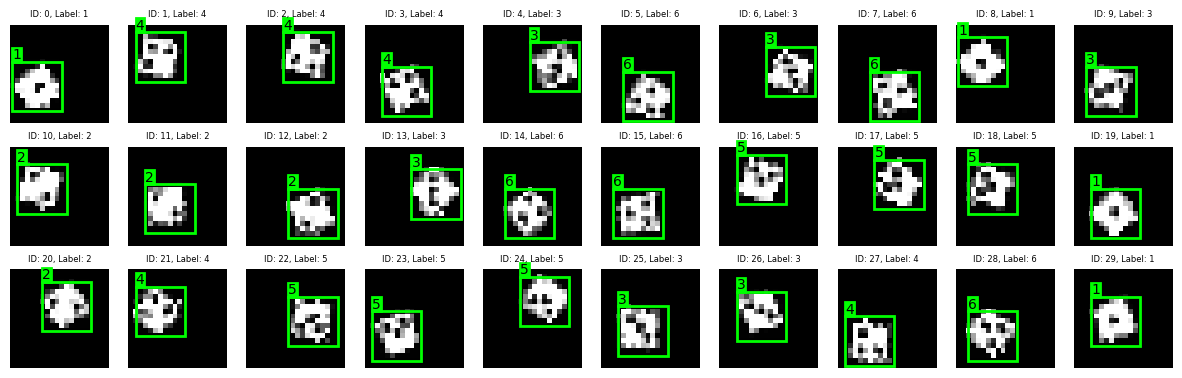

In [38]:
fig, axes = plt.subplots(3, 10, figsize=(15, 4.5))
for i in range(3):
    for j in range(10):
        data, label, data_dict = create_one_dice_data(X, y, i*10+j)
        add_bboxes_to_image(axes[i,j], data, data_dict["boxes"], data_dict["labels"])
        axes[i,j].set_title(f"ID: {data_dict['image_id']}, Label: {label}", fontsize=6)
        axes[i,j].axis('off')
plt.show()

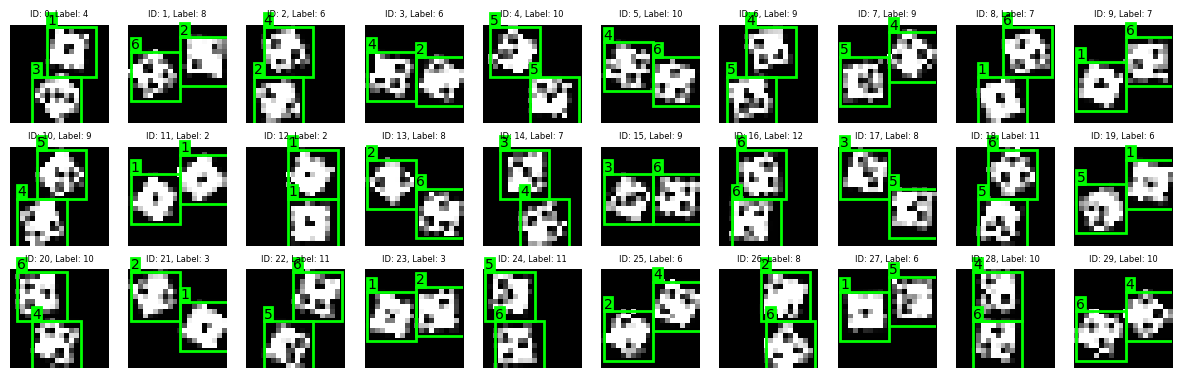

In [39]:
fig, axes = plt.subplots(3, 10, figsize=(15, 4.5))
for i in range(3):
    for j in range(10):
        data, label, data_dict = create_two_dices_data(X, y, i*10+j)
        add_bboxes_to_image(axes[i,j], data, data_dict["boxes"], data_dict["labels"])
        axes[i,j].set_title(f"ID: {data_dict['image_id']}, Label: {label}", fontsize=6)
        axes[i,j].axis('off')
plt.show()

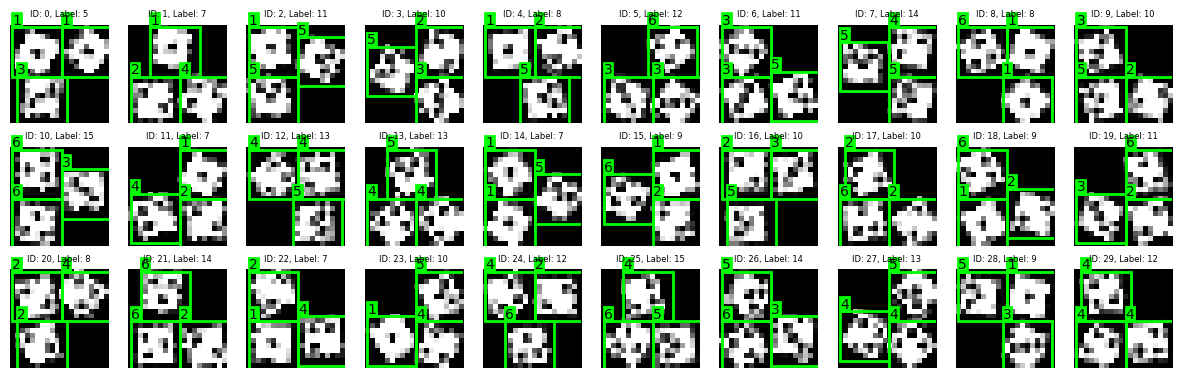

In [40]:
fig, axes = plt.subplots(3, 10, figsize=(15, 4.5))
for i in range(3):
    for j in range(10):
        data, label, data_dict = create_three_dices_data(X, y, i*10+j)
        add_bboxes_to_image(axes[i,j], data, data_dict["boxes"], data_dict["labels"])
        axes[i,j].set_title(f"ID: {data_dict['image_id']}, Label: {label}", fontsize=6)
        axes[i,j].axis('off')
plt.show()

In [41]:
from tqdm import tqdm

X_data, y_data, data_dicts = [], [], []

for i in tqdm(range(3000)):
    if i % 3 == 0:
        # 1 dice
        data, label, data_dict = create_one_dice_data(X, y, i)
        X_data.append(data)
        y_data.append(label)
        data_dicts.append(data_dict)
    elif i % 3 == 1:
        # 2 dices
        data, label, data_dict = create_two_dices_data(X, y, i)
        X_data.append(data)
        y_data.append(label)
        data_dicts.append(data_dict)
    elif i % 3 == 2:
        # 3 dices
        data, label, data_dict = create_three_dices_data(X, y, i)
        X_data.append(data)
        y_data.append(label)
        data_dicts.append(data_dict)

100%|██████████| 3000/3000 [00:00<00:00, 3717.37it/s]


In [42]:
X_data = np.array(X_data)
y_data = np.array(y_data)
data_dicts_df = pd.DataFrame(data_dicts)

X_data.shape, y_data.shape, data_dicts_df.shape

((3000, 20, 20), (3000,), (3000, 5))

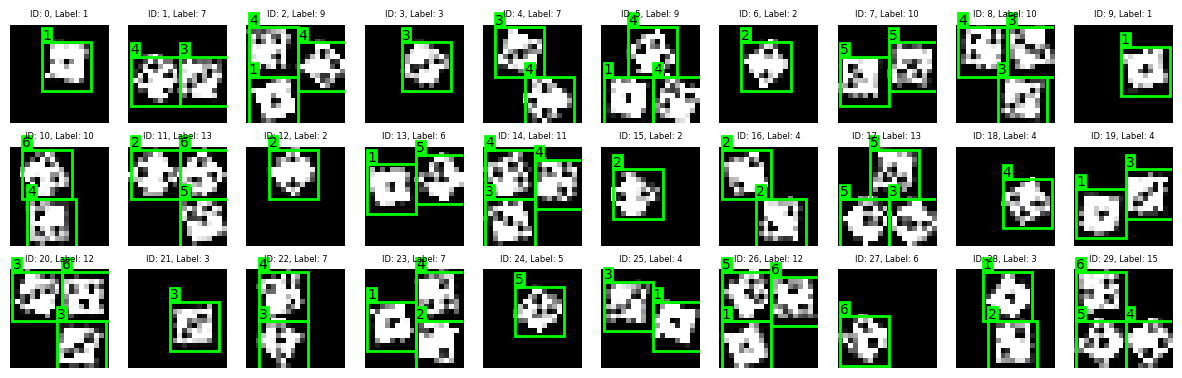

In [43]:
show(X_data, y_data, data_dicts_df)

In [46]:
X_train = np.load(os.path.join(CONF.PATH.DATASET, "all+comp", "X_train_filtered.npy"))
y_train = np.load(os.path.join(CONF.PATH.DATASET, "all+comp", "y_train_filtered.npy"))
data_train = pd.read_json(os.path.join(CONF.PATH.DATASET, "all+comp", "train.json"))

X_train = X_train.reshape(-1, 20, 20)
X_train.shape, y_train.shape, data_train.shape

((192000, 20, 20), (192000,), (192000, 5))

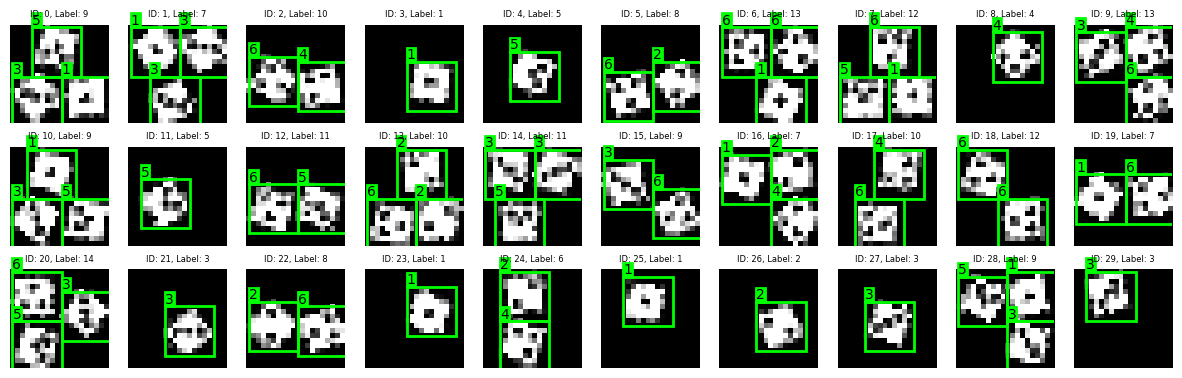

In [47]:
show(X_train, y_train, data_train)